# 1D Maze

This reinforcement learning task utilizes the n-task model in a to solve a simple 1D maze. The 1D maze has multiple goals, but the agent told neither where the goal is nor which goal is currently active. The agent must learn to navigate the maze to locate the goal position.

![](./graphics/1d_maze.png)

In [221]:
# Import Tensorflow and Keras layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

import math
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt

# Import n-task library
from ntask.atr   import AtrModel, AtrMovingAverage
from ntask.layer import Context
from ntask.model import NTaskModel
from ntask.utils import display_progress

In [222]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [223]:
class AtrRl(AtrModel):
    pass

In [224]:
def one_hot_encode(state, n_states):
    a = np.zeros(n_states)
    a[state] = 1
    return np.array([a])

In [225]:
def loss_fn(y, y_pred):
    return tf.keras.losses.mean_squared_error(y, y_pred)

## Maze

In [226]:
class MazeAgent:
    
    # Agent actions
    ACTION_LEFT  = 0
    ACTION_RIGHT = 1
    
    def __init__(self, size, goals, alpha=1.0, gamma=0.75, epsilon=0.2):
        # Maze parameters
        self.maze_size = size
        self.goals     = goals
        
        # Agent parameters
        self.alpha   = alpha   # Q-learning learning rate
        self.gamma   = gamma   # Discount factor
        self.epsilon = epsilon # Epsilon-greedy policy random action probability
        
        # Create the n-task model
        self.init_model()
        
        # Misc
        self.episode = 0
    
    
    def init_model(self):
        inp = Input((self.maze_size,))
        x = Dense(256, activation="relu")(inp)
        x = Context(AtrMovingAverage(num_tasks=len(self.goals)))(x)
        x = Dense(2, activation="linear")(inp)
#         self.model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)
        self.model = Model(inputs=inp, outputs=x)
        self.model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Adam())
        
        
    def policy(self, state):
        """Determine the action given the state"""
        values = self.model.predict(one_hot_encode(state, self.maze_size))[0]
        if random.random() < self.epsilon:
            index = random.randint(0, 1) # left/right
        else:
            index = np.argmax(values)
        return index, values
    
    
    def reward(self, state, goal):
        return int(state == goal)
    
    
    def next_state(self, state, action):
        """Calculate the next state in the maze"""
        if action == MazeAgent.ACTION_LEFT:
            return (state - 1) % self.maze_size
        else:
            return (state + 1) % self.maze_size
        
        
    def random_start_state(self, goal):
        """Generate a random starting state"""
        state = random.randrange(self.maze_size)
        while state == goal:
            state = random.randrange(self.maze_size)
        return state
        
        
    def run(self, goal, limit):
        """Perform an episode"""
        
        self.episode += 1
        
        # Pick a random starting state that is not the goal position
        state = self.random_start_state(goal)
        
        # Initialize prev state, action, action values
        prev_state, action, action_values = None, None, None
        
        # Count the total number of steps
        steps = 0
        
        while state != goal:
            
            # If the step count has been exceeded, terminate with no reward
            if steps > limit:
                return steps
            
            # If the agent has moved, update the previous state's value
            if prev_state is not None:
                # Get the highest valued action at this state
                action_max = np.max(self.model.predict(one_hot_encode(state, self.maze_size)))
                
                # Calculate the TD error with a reward of 0
                td_error = self.reward(state, goal) + self.gamma*action_max - action_values[action]
                
                # Update the target values
                action_values[action] += self.alpha*td_error
                
                # Update the model
                self.model.fit(one_hot_encode(prev_state, self.maze_size), np.array([action_values]), verbose=0)
            
            # Determine the action to make from the policy
            action, action_values = self.policy(state)
            
            # Transition to the next state, remember the previous
            prev_state, state = state, self.next_state(state, action)
            
            # Increment the step            
            steps += 1
            
        # --- At this point the goal has been reached ------------------------
        
        # Absorb the reward
        action_values[action] = self.reward(state, goal)
        self.model.fit(one_hot_encode(prev_state, self.maze_size), np.array([action_values]), verbose=0)
        
        return steps
        
    
    def train(self, episodes, cycles=1, limit=100):
        """Train the agent"""
        
        # Map the goals to context indices
        goal_indices = list(range(len(self.goals)))
        prev_index = None
        
        ep = 1
        total_episodes = episodes*len(self.goals)*cycles
        
        for cycle in range(cycles):
            
            # Shuffle the goals around after first complete cycle
            # Ensures that two goals are not repeated
            if cycle > 0:
                random.shuffle(goal_indices)
                if prev_index == goal_indices[0]:
                    index = random.randrange(1, len(self.goals))
                    goal_indices[0], goal_indices[index] = goal_indices[index], goal_indices[0]
            
            # Perform #episodes per goal
            for goal in goal_indices:
                for episode in range(episodes):
                    self.run(self.goals[goal_indices[goal]], limit)
                    if ep % 1 == 0:
                        display_progress(ep / total_episodes, f"{ep}/{total_episodes}")
                    ep += 1
        
    
    def plot(self):

        # All possible one-hot state encodings
        states = np.identity(10)
        action_labels = ("left", "right")
        
        # Create the plot and x-axis increments
        fig, ax = plt.subplots(figsize=(10,5))
        t = np.arange(0, self.maze_size+1, 1)
        
        for goal in range(len(self.goals)):
            
            # Set the model to the goal's context and grab the action values for each state
            self.model.layers[self.model.context_layers[0]].set_hot_context(goal)
            values = self.model.predict(states)
            
            for i, row in enumerate(np.transpose(values)):
                ax.plot(t, np.append(row, row[0]), 'o-', label=f"ctx({goal}): {action_labels[i]}")
            
        ax.set(xlabel='Position (s)', ylabel='Value Q(s, a)', title="n-task Maze Agent")
        ax.grid()
        plt.legend()
        

## Maze Parameters

In [227]:
set_seed(5)

In [228]:
agent = MazeAgent(10, [0, 5], alpha=1.0, gamma=0.75, epsilon=0.2)

In [ ]:
agent.train(500, 1)

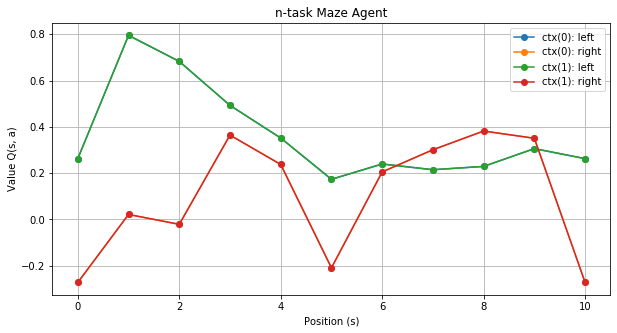

In [230]:
agent.plot()